In [1]:
from Kmeans import kmeans
from FuzzyKMeans import fuzzy_kmeans
from Mountain import mountain
from Substractive import substract
from Agglomerative import agglomerative

from Utils import *
from PlotResults import *

import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as mt
import seaborn as sns
from sklearn import preprocessing

In [2]:
import numpy as np
import matplotlib.image as matimg
from sklearn.manifold import TSNE


from PlotResults import plot_data2d, plot_data3d
img_file = "MNM_small.jpg"
img_name = img_file.split('.')[0]
img = matimg.imread(f"images/{img_file}").astype(int)
img_n, img_m, _ = img.shape
X = img.reshape(img_n * img_m, 3)

In [3]:
def metrics_clusters(X, labels):
    metrics_res = {}
    metrics_res["Silhouette"] = mt.silhouette_score(X, labels)
    metrics_res["Davies-Bouldin"] = mt.davies_bouldin_score(X, labels)
    metrics_res["Calinski-Harabasz"] = mt.calinski_harabasz_score(X, labels)
    return metrics_res

def distance_space(x, y):
    return np.linalg.norm(np.subtract(x,y), ord=np.inf)

In [4]:
max_num_clusters = 12
min_num_clusters = 2


In [5]:
results_metrics = {}
for num_clusters in range(min_num_clusters, max_num_clusters):
    print(f" Iteración número de clusters ", num_clusters)
    # Kmeans
    C, M = kmeans(X, distance_space, num_c=num_clusters, iters=10)
    results_metrics[f"Kmeans_{num_clusters}"] = metrics_clusters(X, M)
    # Cmeans
    C, U = fuzzy_kmeans(X, distance_space, num_c=num_clusters, iters=10)
    M, Umax = fuzzy_to_membership(U)
    results_metrics[f"Cmeans_{num_clusters}"] = metrics_clusters(X, M)
    # Mountain
    C = mountain( X , distance_space, num_c=num_clusters, num_div=5)
    M = calculate_membership( X, C )
    results_metrics[f"Mountain_{num_clusters}"] = metrics_clusters(X, M)
    # Substract
    C = substract(X, distance_space, num_c=num_clusters, num_div=5)
    M = calculate_membership(X, C)
    results_metrics[f"Substract_{num_clusters}"] = metrics_clusters(X, M)
    # agglomerative
    M = agglomerative(X, distance_space, num_c=num_clusters)
    results_metrics[f"Agglomerative_{num_clusters}"] = metrics_clusters(X, M)

 Iteración número de clusters  2
 Iteración número de clusters  3
 Iteración número de clusters  4
 Iteración número de clusters  5
 Iteración número de clusters  6
 Iteración número de clusters  7
 Iteración número de clusters  8
 Iteración número de clusters  9
 Iteración número de clusters  10
 Iteración número de clusters  11


In [7]:
data = pd.DataFrame.from_dict(results_metrics, orient="index")
data["n_clusters"] = data.index.str.split('_').str[-1]
data["model"] = data.index.str.split('_').str[0]


In [8]:
data.to_csv(f"results/{img_name}_inf.csv")

In [9]:
data_manhattan = pd.read_csv(f"results/MNM_small_manhattan.csv", index_col=0)
data_manhattan["metric_space"] = "Manhattan"

In [10]:
data_eucl = pd.read_csv(f"results/MNM_small_euclidean.csv", index_col=0)
data_eucl["metric_space"] = "Euclidean"

In [14]:
data_inf = pd.read_csv(f"results/MNM_small_inf.csv", index_col=0)
data_inf["metric_space"] = "Infinity"

In [15]:
data_norm = pd.concat([data_manhattan, data_eucl, data_inf])

cols_to_norm = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']
min_max_scaler = preprocessing.MinMaxScaler()
data_norm[cols_to_norm] = min_max_scaler.fit_transform(
        data_norm[cols_to_norm]
)
# 
df = data_norm.melt(id_vars=['n_clusters', 'model', "metric_space"],
                   value_vars=cols_to_norm,
                   var_name='metric_name', value_name='value')

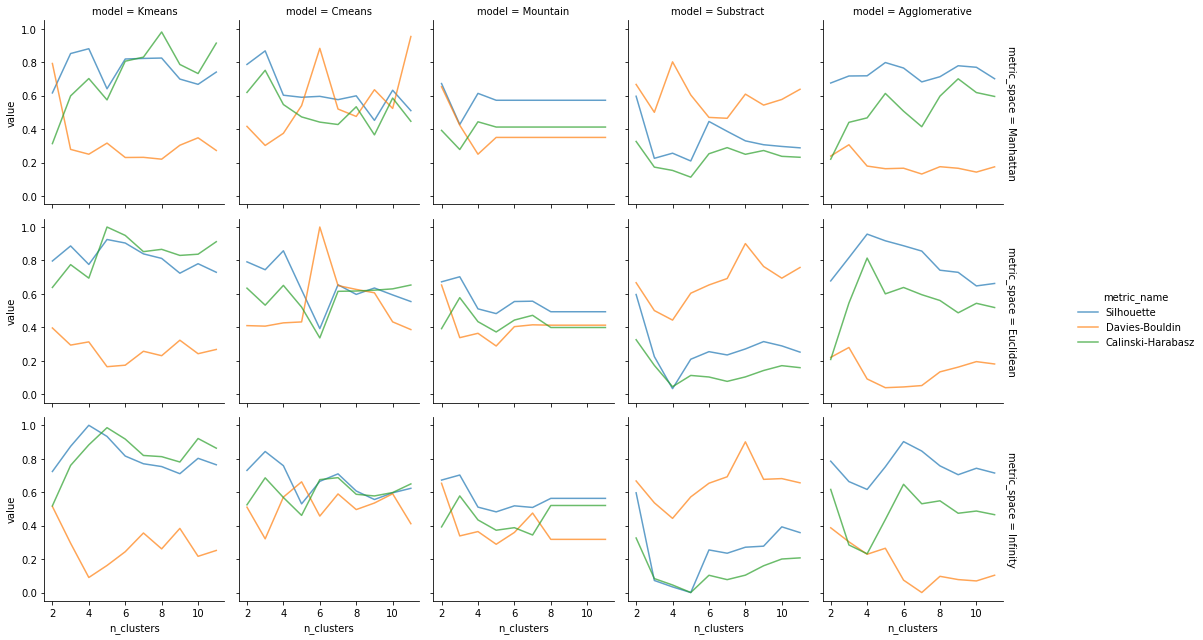

In [16]:
g = sns.FacetGrid(df, col="model", hue='metric_name', row="metric_space",
                    margin_titles=True)
g.map(sns.lineplot, "n_clusters", "value", alpha=.7)
g.add_legend()
g.tight_layout()


In [17]:
g.savefig(f'results/metrics_clusters_{img_name}_all_comps.png')